In [1]:
import zipfile
with zipfile.ZipFile('/content/Дополнительные материалы-20250331.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [77]:
import numpy as np
import pandas as pd
import json

In [3]:
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from pickle import dump

In [4]:
import os

import numpy as np
import pandas as pd


class ClearDataFrames:
    def __init__(self):
        self.customers = None
        self.geolocation = None
        self.order_payments = None
        self.order_reviews = None
        self.orders = None
        self.orders_items = None
        self.product_category_name_translation = None
        self.products = None
        self.sellers = None

    def load_data(self):
        self.customers = pd.read_csv('hackathon/customers.csv')
        self.geolocation = pd.read_csv('hackathon/geolocation.csv')
        self.order_payments = pd.read_csv('hackathon/order_payments.csv')
        self.order_reviews = pd.read_csv('hackathon/order_reviews.csv')
        self.orders = pd.read_csv('hackathon/orders.csv')
        self.orders_items = pd.read_csv('hackathon/orders_items.csv')
        self.product_category_name_translation = pd.read_csv('hackathon/product_category_name_translation.csv')
        self.products = pd.read_csv('hackathon/products.csv')
        self.sellers = pd.read_csv('hackathon/sellers.csv')

    def load_clear_data(self):
        self.customers = pd.read_csv('../cohort_analysis/clear_data/customers.csv') if os.path.exists(
            '../cohort_analysis/clear_data/customers.csv') \
            else pd.read_csv('./data/customers.csv')
        self.geolocation = pd.read_csv('../cohort_analysis/clear_data/geolocation.csv') if os.path.exists(
            '../cohort_analysis/clear_data/geolocation.csv') \
            else pd.read_csv('./data/geolocation.csv')
        self.order_payments = pd.read_csv('../cohort_analysis/clear_data/order_payments.csv') if os.path.exists(
            '../cohort_analysis/clear_data/order_payments.csv') \
            else pd.read_csv('./data/order_payments.csv')
        self.order_reviews = pd.read_csv('../cohort_analysis/clear_data/order_reviews.csv') if os.path.exists(
            '../cohort_analysis/clear_data/order_reviews.csv') \
            else pd.read_csv('./data/order_reviews.csv')
        self.orders = pd.read_csv('../cohort_analysis/clear_data/orders.csv') if os.path.exists(
            '../cohort_analysis/clear_data/orders.csv') \
            else pd.read_csv('./data/orders.csv')
        self.orders_items = pd.read_csv('../cohort_analysis/clear_data/orders_items.csv') if os.path.exists(
            '../cohort_analysis/clear_data/orders_items.csv') \
            else pd.read_csv('data/orders_items.csv')
        self.product_category_name_translation = pd.read_csv(
            '../cohort_analysis/clear_data/product_category_name_translation.csv') \
            if os.path.exists('../cohort_analysis/clear_data/product_category_name_translation.csv') \
            else pd.read_csv('data/product_category_name_translation.csv')
        self.products = pd.read_csv('../cohort_analysis/clear_data/products.csv') if os.path.exists(
            '../cohort_analysis/clear_data/products.csv') \
            else pd.read_csv('data/products.csv')
        self.sellers = pd.read_csv('../cohort_analysis/clear_data/sellers.csv') if os.path.exists(
            '../cohort_analysis/clear_data/sellers.csv') \
            else pd.read_csv('data/sellers.csv')

    def clear_data(self):
        self.__clear_customers()
        self.__clear_products()
        self.__clear_reviews()
        self.__clear_payments()
        self.__clear_orders()
        self.__clear_orders_items()
        self.__clear_geolocation()
        self.__clear_product_category_name_translation()
        self.__clear_sellers()

    def __clear_customers(self):
        customers_with_orders = self.orders['customer_id'].unique()
        self.customers = self.customers[self.customers['customer_id'].isin(customers_with_orders)]

    def __clear_products(self):
        indices_to_drop = self.products[
            ~self.products['product_category_name'].isin(self.product_category_name_translation['product_category_name'])].index
        self.products.drop(indices_to_drop, inplace=True)
        self.products.rename(columns={
            'product_name_lenght': 'product_name_length',
            'product_description_lenght': 'product_description_length'
        }, inplace=True)
        self.products.dropna(inplace=True)

    def __clear_reviews(self):
        self.order_reviews.drop(columns=['Unnamed: 0'], inplace=True)

    def __clear_payments(self):
        self.order_payments.drop(columns=['Unnamed: 0'], inplace=True)
        self.order_payments.drop_duplicates(inplace=True)

        indices_to_drop = self.order_payments[~self.order_payments['order_id'].isin(self.orders['order_id'])].index
        self.order_payments.drop(indices_to_drop, inplace=True)

        indices_to_drop = self.order_payments[self.order_payments['payment_type'] == 'not_defined'].index
        self.order_payments.drop(indices_to_drop, inplace=True)

    def __clear_geolocation(self):
        used_zip_codes = pd.concat([
            self.sellers['seller_zip_code_prefix'],
            self.customers['customer_zip_code_prefix']
        ]).drop_duplicates()

        mask = ~self.geolocation['geolocation_zip_code_prefix'].isin(used_zip_codes)

        self.geolocation = self.geolocation[~mask].copy()
        self.geolocation.drop_duplicates(inplace=True)
        self.geolocation.drop(columns=['Unnamed: 0'], inplace=True)

        def calc_most_state(group):
            res_group = pd.Series({
                'most_state': group['geolocation_state'].value_counts().index[0],
            })
            return res_group

        geolocation_states = (self.geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_state']]
                              .apply(calc_most_state).reset_index())
        self.geolocation = pd.merge(self.geolocation, geolocation_states, on='geolocation_zip_code_prefix', how='left')
        self.geolocation['geolocation_state'] = (self.geolocation['most_state']
                                                 .combine_first(self.geolocation['geolocation_state']))
        self.geolocation.drop(columns=['most_state'], inplace=True)
        q_percent = 0.25

        def find_outliers(group):
            if len(group) >= 2:
                # latitude
                group_unique = group.drop_duplicates(subset=['geolocation_lat', 'geolocation_lng'])
                lats = group['geolocation_lat']
                Q1 = np.quantile(lats, q_percent)
                Q3 = np.quantile(lats, 1 - q_percent)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                group = group[
                    (group['geolocation_lat'] >= lower_bound) &
                    (group['geolocation_lat'] <= upper_bound)
                    ]

                # longitude
                lngs = group['geolocation_lng']
                Q1 = np.quantile(lngs, q_percent)
                Q3 = np.quantile(lngs, 1 - q_percent)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                group = group[
                    (group['geolocation_lng'] >= lower_bound) &
                    (group['geolocation_lng'] <= upper_bound)
                    ]
                return group
            return group

        # self.geolocation = self.geolocation.groupby('geolocation_state').apply(find_outliers).reset_index(drop=True)
        self.geolocation = self.geolocation.groupby('geolocation_zip_code_prefix').apply(find_outliers).reset_index(drop=True)

    def __clear_orders(self):
        delivered = self.orders[self.orders['order_status'] == 'delivered']
        drop_i = delivered[delivered.isna().any(axis=1)].index  # delivered orders with NaN timestamps
        self.orders.drop(index=drop_i, inplace=True)
        self.orders.drop_duplicates(inplace=True)

    def __clear_orders_items(self):
        try:
            self.orders_items.drop(['freight_value.1', 'shipping_limit_date.1', 'price.1'], axis=1, inplace=True)
        except Exception:
            pass

        indices_to_drop = self.orders_items[~self.orders_items['order_id'].isin(self.orders['order_id'])].index
        self.orders_items.drop(indices_to_drop, inplace=True)

        self.orders_items.drop(columns=['Unnamed: 0'], inplace=True)

        self.orders_items.drop_duplicates(inplace=True)

    def __clear_product_category_name_translation(self):
        self.product_category_name_translation.drop(columns=['Unnamed: 0'], inplace=True)

    def __clear_sellers(self):
        self.sellers.drop(columns=['Unnamed: 0'], inplace=True)

        invalid_cities = [
            '04482255',
            'vendas@creditparts.com.br',
            'rio de janeiro / rio de janeiro',
            'sao paulo / sao paulo',
            'rio de janeiro \\rio de janeiro',
            'ribeirao preto / sao paulo',
            'sp',
            'carapicuiba / sao paulo',
            'mogi das cruzes / sp',
            'sp / sp',
            'auriflama/sp',
            'pinhais/pr',
            'cariacica / es',
            'jacarei / sao paulo',
            'sao sebastiao da grama/sp',
            'maua/sao paulo',
            ' ',
            'lages - sc'
        ]

        indices_to_drop = self.sellers[self.sellers['seller_city'].isin(invalid_cities)].index
        self.sellers.drop(indices_to_drop, inplace=True)

In [5]:
data = ClearDataFrames()
data.load_data()
data.clear_data()

<ipython-input-4-d952927ca47b>:25: DtypeWarning: Columns (1,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  self.orders_items = pd.read_csv('hackathon/orders_items.csv')
<ipython-input-4-d952927ca47b>:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.geolocation = self.geolocation.groupby('geolocation_zip_code_prefix').apply(find_outliers).reset_index(drop=True)


In [6]:
days_th = 231
max_date = data.orders['order_purchase_timestamp'].map(lambda x: pd.Timestamp(x)).max()

In [ ]:
def compile_data_to_one_place(data):
  dataset = data.orders.copy()
  dataset = dataset.merge(data.customers.drop(columns=['customer_zip_code_prefix', 'customer_city', 'customer_state']), on='customer_id').drop(columns=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
  dataset = dataset[~dataset['order_status'].isin(['unavailable', 'canceled'])]
  dataset = dataset.drop(columns=['order_status'])
  dataset['order_purchase_timestamp'] = dataset['order_purchase_timestamp'].map(lambda x: pd.Timestamp(x))
  dataset = dataset.merge(data.order_reviews[['order_id', 'review_score']], on='order_id', how='left')
  mean_score = dataset['review_score'].dropna().values.mean()
  dataset.fillna({'review_score': mean_score}, inplace=True)
  dataset = dataset.merge(data.order_payments.drop_duplicates(subset=['order_id'])[['order_id', 'payment_value']], on='order_id').drop(columns=['customer_id', 'order_id'])
  return dataset

In [ ]:
def compile_info_about_customer(customer):
  rows = customer.shape[0]
  info = {
        'orders_count': rows,
        'last_score': customer.iloc[-1]['review_score'],
        'last_payment': customer.iloc[-1]['payment_value'],
        'last_days_between_orders': (customer.iloc[-1]['order_purchase_timestamp'] - customer.iloc[-2]['order_purchase_timestamp']).days if rows > 1 else np.nan, # rows > 1?
        'mean_score': customer.iloc[0:-1]['review_score'].mean() if rows > 1 else np.nan, # rows > 1?
        'mean_payment': customer.iloc[0:-1]['payment_value'].mean() if rows > 1 else np.nan, # rows > 1?
        'mean_days_between_orders': (customer.iloc[-2]['order_purchase_timestamp'] - customer.iloc[0]['order_purchase_timestamp']).days * 1.0 / (rows - 2) if rows > 2 else np.nan # rows > 2?
        }
  return info

In [ ]:
def create_dataset(data, max_date, should_expand_dataset=True, keep_1_orders_customers = None, keep_fields_with_1_order = True, target_days_th = None):
  dataset = compile_data_to_one_place(data)
  if keep_1_orders_customers is not None:
    tmp = dataset.groupby('customer_unique_id').count().reset_index()
    id_with_1_order = tmp[tmp['review_score'] == 1]['customer_unique_id'].values   # dataset['review_score'] | we can use any column because they are same
    rng = np.random.default_rng(1)
    id_with_1_order = rng.choice(id_with_1_order, keep_1_orders_customers, replace=False)
    id_with_ge2_orders = tmp[tmp['review_score'] > 1]['customer_unique_id'].values # dataset['review_score'] | we can use any column because they are same
    ids = np.concat((id_with_1_order, id_with_ge2_orders))
    dataset = dataset[dataset['customer_unique_id'].isin(ids)]

  expand_dataset = pd.DataFrame()

  for id, group in dataset.groupby('customer_unique_id'):
    group = group.sort_values(by='order_purchase_timestamp')
    for i in range(group.shape[0]) if should_expand_dataset else [group.shape[0] - 1]:
      row = compile_info_about_customer(group.iloc[0:i + 1])
      row['customer_unique_id'] = id
      row['days_after_order'] = (max_date - group.iloc[i]['order_purchase_timestamp']).days
      if target_days_th:
        row['retention'] = 0 if i == group.shape[0] - 1 and (max_date - group.iloc[i]['order_purchase_timestamp']).days >= target_days_th else 1

      if expand_dataset.shape[0] == 0:
          expand_dataset = pd.DataFrame(columns=row)
      expand_dataset.loc[len(expand_dataset)] = row

  if not keep_fields_with_1_order:
    expand_dataset = expand_dataset[expand_dataset['orders_count'] > 1]

  return expand_dataset

In [ ]:
d = create_dataset(data, max_date, should_expand_dataset=False, keep_1_orders_customers=0, keep_fields_with_1_order=True, target_days_th=days_th)

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2971 entries, 0 to 2970
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   orders_count              2971 non-null   int64  
 1   last_score                2971 non-null   float64
 2   last_payment              2971 non-null   float64
 3   last_days_between_orders  2971 non-null   int64  
 4   mean_score                2971 non-null   float64
 5   mean_payment              2971 non-null   float64
 6   mean_days_between_orders  548 non-null    float64
 7   customer_unique_id        2971 non-null   object 
 8   days_after_order          2971 non-null   int64  
 9   retention                 2971 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 255.3+ KB


In [ ]:
d.groupby('retention').count()

,orders_count,last_score,last_payment,last_days_between_orders,mean_score,mean_payment,mean_days_between_orders,customer_unique_id,days_after_order
retention,,,,,,,,,
0,1676,1676,1676,1676,1676,1676,362,1676,1676
1,1295,1295,1295,1295,1295,1295,186,1295,1295


In [ ]:
split_num = 4
group_kfold = GroupKFold(n_splits=split_num, random_state=1, shuffle=True)
splits = group_kfold.split(d.drop(columns=['retention']), d['retention'], d['customer_unique_id'])
(train, test) = next(splits)
train_X, train_y = d.iloc[train].drop(columns=['retention', 'customer_unique_id']), d.iloc[train]['retention']

group_kfold = GroupKFold(n_splits=2, random_state=1, shuffle=True)
splits = group_kfold.split(d.iloc[test].drop(columns=['retention']), d.iloc[test]['retention'], d.iloc[test]['customer_unique_id'])
(valid, test) = next(splits)
valid_X, valid_y = d.iloc[valid].drop(columns=['retention', 'customer_unique_id']), d.iloc[valid]['retention']
test_X, test_y = d.iloc[test].drop(columns=['retention', 'customer_unique_id']), d.iloc[test]['retention']

In [ ]:
train_X.shape, valid_X.shape, test_X.shape

((2228, 8), (371, 8), (372, 8))

# Random Forest

In [ ]:
model = RandomForestClassifier(random_state=1)
model.fit(train_X.drop(columns=['days_after_order']), train_y)

RandomForestClassifier(random_state=1)

In [ ]:
model.score(valid_X.drop(columns=['days_after_order']), valid_y)

0.9164420485175202

In [ ]:
with open("sub_rfc.pkl", "wb") as f:
    dump(model, f, protocol=5)

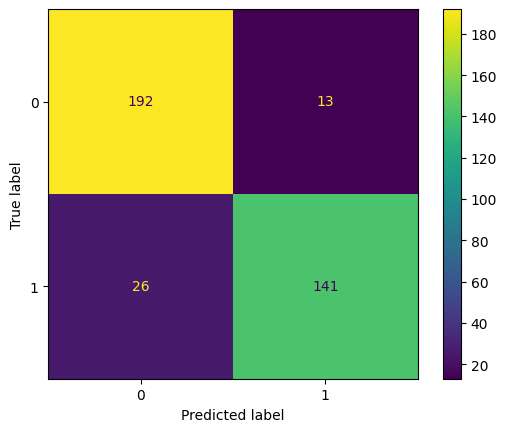

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_y, model.predict(test_X.drop(columns=['days_after_order'])), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

# Gradient Boosting (Attempt)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model2 = GradientBoostingClassifier(random_state=0)
model2.fit(train_X.drop(columns=['mean_days_between_orders', 'date']), train_y)
model2.score(valid_X.drop(columns=['mean_days_between_orders', 'date']), valid_y)

0.6453781512605042

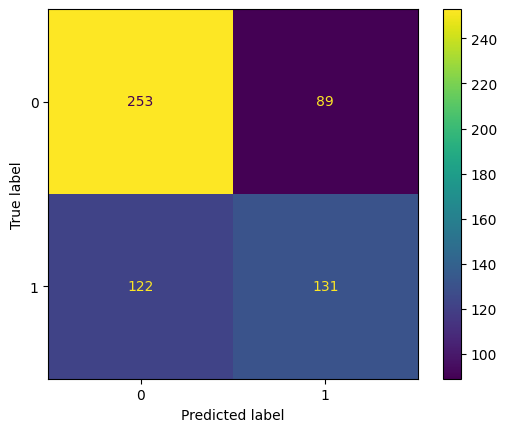

In [ ]:
cm = confusion_matrix(test_y, model2.predict(test_X.drop(columns=['mean_days_between_orders', 'date'])), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

# Regression for customers with > 1 orders

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

reg_dataset = pd.DataFrame(columns=['days_after_order', 'rfc'])
reg_dataset['days_after_order'] = valid_X['days_after_order']
reg_dataset['rfc'] = model.predict_proba(valid_X.drop(columns=['days_after_order']))[:,1]

reg_dataset_test = pd.DataFrame(columns=['days_after_order', 'rfc'])
reg_dataset_test['days_after_order'] = test_X['days_after_order']
reg_dataset_test['rfc'] = model.predict_proba(test_X.drop(columns=['days_after_order']))[:,1]


pipeline_model = make_pipeline(StandardScaler(),
                               LogisticRegression())

pipeline_model.fit(reg_dataset, valid_y)
pipeline_model.score(reg_dataset_test, test_y)

0.9838709677419355

In [ ]:
with open("model_for_several_orders.pkl", "wb") as f:
    dump(pipeline_model, f, protocol=5)

# Regression for customers with 1 order

In [ ]:
explicit_dataset = compile_data_to_one_place(data)
tmp = explicit_dataset.groupby('customer_unique_id').count().reset_index()
id_with_1_order = tmp[tmp['review_score'] == 1]['customer_unique_id'].values
explicit_dataset = explicit_dataset[explicit_dataset['customer_unique_id'].isin(id_with_1_order)].drop(columns=['customer_unique_id'])
explicit_dataset['days_after_order'] = (max_date - explicit_dataset['order_purchase_timestamp']).map(lambda x: x.days)
explicit_dataset.drop(columns=['order_purchase_timestamp'], inplace=True)
explicit_dataset['retention'] = explicit_dataset['days_after_order'].map(lambda x: 0 if x >= days_th else 1)
explicit_dataset

,review_score,payment_value,days_after_order,retention
1,4.0,141.46,84,1
2,5.0,179.12,70,1
3,5.0,72.20,332,0
4,5.0,28.62,245,0
5,4.0,175.26,464,0
...,...,...,...,...
98723,5.0,85.08,587,0
98724,4.0,195.00,253,0
98725,5.0,271.01,416,0
98726,2.0,441.16,281,0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
o1_X_train, o1_X_test, o1_y_train, o1_y_test = train_test_split(explicit_dataset.drop(columns=['retention']), explicit_dataset['retention'], test_size=0.2, random_state=1)

o1_pipeline_model = make_pipeline(StandardScaler(),
                                  LogisticRegression())

o1_pipeline_model.fit(o1_X_train, o1_y_train)
o1_pipeline_model.score(o1_X_test, o1_y_test)

0.9998369565217391

In [ ]:
with open("model_for_1_order.pkl", "wb") as f:
    dump(o1_pipeline_model, f, protocol=5)

In [ ]:
o1_pipeline_model.predict_proba(o1_X_test.iloc[20].to_frame().T)

array([[3.56724738e-08, 9.99999964e-01]])

In [ ]:
o1_pipeline_model.get_params()['logisticregression'].coef_

array([[-4.73459182e-02,  2.34480648e-02, -3.53068338e+01]])

# Model

### Several orders

In [ ]:
def prepare_data_for_several_order_model(compiled_data, current_date):
  tmp = compiled_data.groupby('customer_unique_id').count().reset_index()
  id_with_ge2_orders = tmp[tmp['review_score'] > 1]['customer_unique_id'].values # dataset['review_score'] | we can use any column because they are same
  tmp_data = compiled_data[compiled_data['customer_unique_id'].isin(id_with_ge2_orders)]
  data = pd.DataFrame()

  for _, group in tmp_data.groupby('customer_unique_id'):
    group = group.sort_values(by='order_purchase_timestamp')
    i = group.shape[0] - 1
    row = compile_info_about_customer(group)
    row['days_after_order'] = (current_date - group.iloc[-1]['order_purchase_timestamp']).days

    if data.shape[0] == 0:
        data = pd.DataFrame(columns=row)
    data.loc[len(data)] = row

  return data

In [ ]:
from pathlib import Path
from pickle import load

class SeveralOrdersModel:
  def __init__(self, models_dir=""):
    with open(Path(models_dir) / Path("sub_rfc.pkl"), "rb") as f:
        self.sub_rfc = load(f)
    with open(Path(models_dir) / Path("model_for_several_orders.pkl"), "rb") as f:
        self.several_orders_model = load(f)

  def predict(self, X):
    interim_data = pd.DataFrame(columns=['days_after_order', 'rfc'])
    interim_data['days_after_order'] = X['days_after_order']
    interim_data['rfc'] = self.sub_rfc.predict_proba(X.drop(columns=['days_after_order']))[:,1]
    preds = self.several_orders_model.predict(interim_data)
    return preds

  def predict_proba(self, X):
    interim_data = pd.DataFrame(columns=['days_after_order', 'rfc'])
    interim_data['days_after_order'] = X['days_after_order']
    interim_data['rfc'] = self.sub_rfc.predict_proba(X.drop(columns=['days_after_order']))[:,1]
    probas = self.several_orders_model.predict_proba(interim_data)[:, 1]
    return probas

In [ ]:
m = SeveralOrdersModel()
test_data = prepare_data_for_several_order_model(compile_data_to_one_place(data), max_date)
display(test_data)
m.predict(test_data)

,orders_count,last_score,last_payment,last_days_between_orders,mean_score,mean_payment,mean_days_between_orders,days_after_order
0,2,4.0,46.85,0,5.000000,46.850000,NaN,383
1,2,5.0,103.28,170,5.000000,251.090000,NaN,276
2,2,5.0,49.85,267,1.000000,97.870000,NaN,143
3,2,4.0,26.78,10,4.000000,96.470000,NaN,136
4,4,3.0,81.78,0,4.333333,56.873333,0.0,574
...,...,...,...,...,...,...,...,...
2966,2,1.0,166.46,9,1.000000,166.460000,NaN,44
2967,2,3.0,0.53,0,3.000000,0.720000,NaN,515
2968,3,1.0,66.74,0,3.500000,165.070000,186.0,324
2969,3,5.0,42.58,22,4.000000,48.510000,182.0,398


array([0, 0, 1, ..., 0, 0, 0])

### One order

In [ ]:
def prepare_data_for_one_order_model(compiled_data, max_date):
  tmp = compiled_data.groupby('customer_unique_id').count().reset_index()
  id_with_1_order = tmp[tmp['review_score'] == 1]['customer_unique_id'].values
  data = compiled_data[compiled_data['customer_unique_id'].isin(id_with_1_order)].drop(columns=['customer_unique_id']).copy()
  data['days_after_order'] = (max_date - data['order_purchase_timestamp']).map(lambda x: x.days)
  data = data[['review_score', 'payment_value', 'days_after_order']]
  return data

In [ ]:
class OneOrderModel:
  def __init__(self, model_dir=""):
    with open(Path(model_dir) / Path("model_for_1_order.pkl"), "rb") as f:
        self.one_order_model = load(f)

  def predict(self, X):
    return  self.one_order_model.predict(X)

  def predict_proba(self, X):
    return self.one_order_model.predict_proba(X)[:, 1]


In [ ]:
m = OneOrderModel()
test_data = prepare_data_for_one_order_model(compile_data_to_one_place(data), max_date)
display(test_data)
m.predict(test_data)

,review_score,payment_value,days_after_order
1,4.0,141.46,84
2,5.0,179.12,70
3,5.0,72.20,332
4,5.0,28.62,245
5,4.0,175.26,464
...,...,...,...
98723,5.0,85.08,587
98724,4.0,195.00,253
98725,5.0,271.01,416
98726,2.0,441.16,281


array([1, 1, 0, ..., 0, 0, 1])

# Playground

In [7]:
product_clusters = {
    "health_beauty": [
        "health_beauty",
        "perfumery",
        "diapers_and_hygiene"
    ],
    "electronics_technology": [
        "computers_accessories",
        "telephony",
        "tablets_printing_image",
        "fixed_telephony",
        "consoles_games",
        "audio",
        "electronics",
        "small_appliances",
        "home_appliances",
        "home_appliances_2",
        "small_appliances_home_oven_and_coffee",
        "cine_photo",
        "cds_dvds_musicals",
        "dvds_blu_ray",
        "computers"
    ],
    "automotive": [
        "auto"
    ],
    "home_furniture_decor": [
        "bed_bath_table",
        "furniture_decor",
        "kitchen_dining_laundry_garden_furniture",
        "furniture_mattress_and_upholstery",
        "furniture_living_room",
        "furniture_bedroom",
        "office_furniture",
        "home_confort",
        "home_comfort_2",
        "home_construction",
        "la_cuisine",
        "air_conditioning"
    ],
    "fashion_accessories": [
        "fashion_bags_accessories",
        "fashion_shoes",
        "fashion_male_clothing",
        "fashio_female_clothing",
        "fashion_underwear_beach",
        "fashion_sport",
        "luggage_accessories",
        "watches_gifts",
        "sports_leisure"
    ],
    "construction_industry": [
        "construction_tools_construction",
        "costruction_tools_garden",
        "costruction_tools_tools",
        "construction_tools_lights",
        "construction_tools_safety",
        "industry_commerce_and_business",
        "agro_industry_and_commerce",
        "signaling_and_security",
        "security_and_services"
    ],
    "food_drinks": [
        "food_drink",
        "drinks",
        "food",
        "party_supplies"
    ],
    "baby_kids": [
        "baby",
        "toys",
        "fashion_childrens_clothes"
    ],
    "books": [
        "books_technical",
        "books_general_interest",
        "books_imported"
    ],
    'art': [
        "music",
        "art",
        "arts_and_craftmanship",
        "stationery",
        "musical_instruments"
    ],
    "home_lifestyle_misc": [
        "garden_tools",
        "flowers",
        "cool_stuff",
        "market_place",
        "christmas_supplies",
        "housewares"
    ],
    "pets": [
        "pet_shop"
    ]
}

In [78]:
with open("category_table.json", "w") as outfile:
    json.dump(product_clusters, outfile, indent=4, sort_keys=False)

In [8]:
p = data.products[['product_id', 'product_category_name']].copy()
pr = data.product_category_name_translation.copy()
pr['upper_category'] = ''
for n in data.product_category_name_translation['product_category_name_english'].unique():
  for c in product_clusters.keys():
    if n in product_clusters[c]:
      pr.loc[pr['product_category_name_english'] == n, 'upper_category'] = c
p = p.merge(pr, how='left', on='product_category_name').drop(columns=['product_category_name', 'product_category_name_english'])
p

,product_id,upper_category
0,1e9e8ef04dbcff4541ed26657ea517e5,health_beauty
1,3aa071139cb16b67ca9e5dea641aaa2f,art
2,96bd76ec8810374ed1b65e291975717f,fashion_accessories
3,cef67bcfe19066a932b7673e239eb23d,baby_kids
4,9dc1a7de274444849c219cff195d0b71,home_lifestyle_misc
...,...,...
32322,a0b7d5a992ccda646f2d34e418fff5a0,home_furniture_decor
32323,bf4538d88321d0fd4412a93c974510e6,construction_industry
32324,9a7c6041fa9592d9d9ef6cfe62a71f8c,home_furniture_decor
32325,83808703fc0706a22e264b9d75f04a2e,electronics_technology


In [9]:
d = data.orders_items.copy()
tmp = d.groupby('order_id').count()
tmp = tmp.rename(columns={'freight_value':'count'})
tmp = tmp.reset_index()
d = d.merge(tmp[['order_id','count']], how='left', on='order_id')
d = d.merge(p, how='left', on='product_id').drop(columns=['product_id']).fillna({'upper_category':'miss'})
d.groupby('upper_category').count()
d = d.merge(data.sellers[['seller_id', 'seller_zip_code_prefix']], how='left', on='seller_id')
d.fillna({'seller_zip_code_prefix': 0.0}, inplace=True)
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112626 entries, 0 to 112625
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                112626 non-null  object 
 1   order_item_id           112626 non-null  float64
 2   seller_id               112626 non-null  object 
 3   shipping_limit_date     112626 non-null  object 
 4   price                   112626 non-null  float64
 5   freight_value           112626 non-null  float64
 6   count                   112626 non-null  int64  
 7   upper_category          112626 non-null  object 
 8   seller_zip_code_prefix  112626 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 7.7+ MB


In [10]:
orders = pd.DataFrame(columns=['order_id', 'upper_category', 'seller_zip_code_prefix'])
for id, group in d.groupby('order_id'):
    row = {
        'order_id': id,
        'upper_category': group['upper_category'] if group.count == 1 else group.groupby('upper_category').sum()['price'].idxmax(),
        'seller_zip_code_prefix': group.iloc[0]['seller_zip_code_prefix']
    }
    orders.loc[len(orders)] = row
orders

,order_id,upper_category,seller_zip_code_prefix
0,00010242fe8c5a6d1ba2dd792cb16214,home_lifestyle_misc,27277.0
1,00018f77f2f0320c557190d7a144bdd3,pets,3471.0
2,000229ec398224ef6ca0657da4fc703e,home_furniture_decor,37564.0
3,00024acbcdf0a6daa1e931b038114c75,health_beauty,14403.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,home_lifestyle_misc,87900.0
...,...,...,...
98638,fffc94f6ce00a00581880bf54a75a037,home_lifestyle_misc,88303.0
98639,fffcd46ef2263f404302a634eb57f7eb,electronics_technology,1206.0
98640,fffce4705a9662cd70adb13d4a31832d,fashion_accessories,80610.0
98641,fffe18544ffabc95dfada21779c9644f,electronics_technology,4733.0


In [11]:
  orders_ = orders.merge(data.order_reviews.drop_duplicates(subset=['order_id'])[['order_id', 'review_score']], on='order_id', how='inner')
  mean_score = orders_['review_score'].dropna().values.mean()
  orders_.fillna({'review_score': mean_score}, inplace=True)
  orders_ = orders_.merge(data.order_payments.drop_duplicates(subset=['order_id'])[['order_id', 'payment_value']], on='order_id', how='inner')

  orders_

,order_id,upper_category,seller_zip_code_prefix,review_score,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,home_lifestyle_misc,27277.0,5,72.19
1,00018f77f2f0320c557190d7a144bdd3,pets,3471.0,4,259.83
2,000229ec398224ef6ca0657da4fc703e,home_furniture_decor,37564.0,5,216.87
3,00024acbcdf0a6daa1e931b038114c75,health_beauty,14403.0,4,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,home_lifestyle_misc,87900.0,5,218.04
...,...,...,...,...,...
97888,fffc94f6ce00a00581880bf54a75a037,home_lifestyle_misc,88303.0,5,343.40
97889,fffcd46ef2263f404302a634eb57f7eb,electronics_technology,1206.0,5,386.53
97890,fffce4705a9662cd70adb13d4a31832d,fashion_accessories,80610.0,5,116.85
97891,fffe18544ffabc95dfada21779c9644f,electronics_technology,4733.0,5,64.71


In [12]:
tmp_orders = data.orders.copy()
tmp_orders = tmp_orders.merge(data.customers.drop(columns=['customer_city', 'customer_state']), on='customer_id').drop(columns=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
tmp_orders = tmp_orders[~tmp_orders['order_status'].isin(['unavailable', 'canceled'])]
tmp_orders = tmp_orders.drop(columns=['order_status'])
tmp_orders['order_purchase_timestamp'] = tmp_orders['order_purchase_timestamp'].map(lambda x: pd.Timestamp(x))
tmp_orders

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,59296
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,9195
...,...,...,...,...,...
99413,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,12209
99414,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,11722
99415,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,45920
99416,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,28685


In [13]:
dataset = orders_.merge(tmp_orders, on='order_id', how='inner').drop(columns=['order_id'])
dataset

,upper_category,seller_zip_code_prefix,review_score,payment_value,customer_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix
0,home_lifestyle_misc,27277.0,5,72.19,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,28013
1,pets,3471.0,4,259.83,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,15775
2,home_furniture_decor,37564.0,5,216.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,35661
3,health_beauty,14403.0,4,25.78,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12952
4,home_lifestyle_misc,87900.0,5,218.04,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,13226
...,...,...,...,...,...,...,...,...
97438,home_lifestyle_misc,88303.0,5,343.40,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,0c9aeda10a71f369396d0c04dce13a64,65077
97439,electronics_technology,1206.0,5,386.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,0da9fe112eae0c74d3ba1fe16de0988b,81690
97440,fashion_accessories,80610.0,5,116.85,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,cd79b407828f02fdbba457111c38e4c4,4039
97441,electronics_technology,4733.0,5,64.71,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,eb803377c9315b564bdedad672039306,13289


In [14]:
tmp = dataset.groupby('customer_unique_id').count().reset_index()
id_with_1_order = tmp[tmp['review_score'] == 1]['customer_unique_id'].values
one_order = dataset[dataset['customer_unique_id'].isin(id_with_1_order)]
several_orders = dataset[~dataset['customer_unique_id'].isin(id_with_1_order)]

In [15]:
collapsed_ds = pd.DataFrame(columns=several_orders.columns)
for id, orders_group in several_orders.groupby('customer_unique_id'):
  orders_group = orders_group.sort_values(by='order_purchase_timestamp')
  collapsed_ds.loc[len(collapsed_ds)] = orders_group.iloc[0]
  cat_table = dict.fromkeys(product_clusters.keys(), 0.0)
  cat_table['miss'] = 0.0
  cat_table[collapsed_ds.iloc[-1]['upper_category']] = float(collapsed_ds.iloc[-1]['payment_value'])
  size = 1
  for i in range(1, orders_group.shape[0]):
    row = len(collapsed_ds) - 1
    t_delta = (orders_group.iloc[i]['order_purchase_timestamp'] - collapsed_ds.iloc[row]['order_purchase_timestamp']).days
    if t_delta >= 1 or i == orders_group.shape[0] - 1:
      collapsed_ds.at[row, 'review_score'] /= size
      size = 1
      collapsed_ds.at[row, 'upper_category'] = max(cat_table, key=cat_table.get)
      cat_table = dict.fromkeys(cat_table, 0.0)
      if  t_delta >= 1:
        collapsed_ds.loc[len(collapsed_ds)] = orders_group.iloc[i]
        cat_table[collapsed_ds.iloc[-1]['upper_category']] = float(collapsed_ds.iloc[-1]['payment_value'])
    else:
      cat_table[orders_group.iloc[i]['upper_category']] += orders_group.iloc[i]['payment_value']
      collapsed_ds.at[row, 'payment_value'] += float(orders_group.iloc[i]['payment_value'])
      collapsed_ds.at[row, 'review_score'] += orders_group.iloc[i]['review_score']
      size += 1
collapsed_ds

,upper_category,seller_zip_code_prefix,review_score,payment_value,customer_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix
0,home_lifestyle_misc,3426.0,5.0,251.09,1b4a75b3478138e99902678254b260f4,2017-07-27 14:13:03,004288347e5e88a27ded2bb23747066c,26220
1,fashion_accessories,31255.0,5,103.28,f6efe5d5c7b85e12355f9d5c3db46da2,2018-01-14 07:36:54,004288347e5e88a27ded2bb23747066c,26220
2,home_lifestyle_misc,15025.0,1.0,97.87,49cf243e0d353cd418ca77868e24a670,2017-09-01 12:11:23,004b45ec5c64187465168251cd1c9c2f,57055
3,home_furniture_decor,3204.0,5,49.85,d95f60d70d9ea9a7fe37c53c931940bb,2018-05-26 19:42:48,004b45ec5c64187465168251cd1c9c2f,57035
4,fashion_accessories,17209.0,4.0,96.47,876356df457f952458a764348e1858bc,2018-05-23 20:14:21,00a39521eb40f7012db50455bf083460,72595
...,...,...,...,...,...,...,...,...
5060,home_furniture_decor,14940.0,2,66.74,e53e1eedc9ebf9fa7a3318c60ece1d25,2017-11-26 23:25:43,ff8892f7c26aa0446da53d01b18df463,45972
5061,fashion_accessories,35700.0,5.0,39.42,1ae563fdfa500d150be6578066d83998,2017-02-22 12:26:42,ff922bdd6bafcdf99cb90d7f39cea5b3,17340
5062,home_furniture_decor,81020.0,3.0,57.6,d064be88116eb8b958727aec4cf56a59,2017-08-23 13:15:29,ff922bdd6bafcdf99cb90d7f39cea5b3,17340
5063,home_lifestyle_misc,3929.0,5,42.58,bec0bf00ac5bee64ce8ef5283051a70c,2017-09-14 14:24:04,ff922bdd6bafcdf99cb90d7f39cea5b3,17340


In [16]:
tmp = collapsed_ds.groupby('customer_unique_id').count().reset_index()
id_with_1_order_additional = tmp[tmp['review_score'] == 1]['customer_unique_id'].values
one_order = dataset[dataset['customer_unique_id'].isin(np.concat([id_with_1_order, id_with_1_order_additional]))]

several_orders = collapsed_ds.copy()
tmp = several_orders.groupby('customer_unique_id').count()
tmp = tmp.rename(columns={'payment_value':'count'})
tmp = tmp.reset_index()
several_orders = several_orders.merge(tmp[['customer_unique_id','count']], how='left', on='customer_unique_id')
tmp = several_orders.groupby('customer_unique_id').agg(same=('upper_category', lambda x: max(np.unique(x, return_counts=True)[1])))
tmp = tmp.reset_index()
several_orders = several_orders.merge(tmp[['customer_unique_id','same']], how='left', on='customer_unique_id')
several_orders = several_orders[several_orders['count'] > 1]
several_orders

,upper_category,seller_zip_code_prefix,review_score,payment_value,customer_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,count,same
0,home_lifestyle_misc,3426.0,5.0,251.09,1b4a75b3478138e99902678254b260f4,2017-07-27 14:13:03,004288347e5e88a27ded2bb23747066c,26220,2,1
1,fashion_accessories,31255.0,5,103.28,f6efe5d5c7b85e12355f9d5c3db46da2,2018-01-14 07:36:54,004288347e5e88a27ded2bb23747066c,26220,2,1
2,home_lifestyle_misc,15025.0,1.0,97.87,49cf243e0d353cd418ca77868e24a670,2017-09-01 12:11:23,004b45ec5c64187465168251cd1c9c2f,57055,2,1
3,home_furniture_decor,3204.0,5,49.85,d95f60d70d9ea9a7fe37c53c931940bb,2018-05-26 19:42:48,004b45ec5c64187465168251cd1c9c2f,57035,2,1
4,fashion_accessories,17209.0,4.0,96.47,876356df457f952458a764348e1858bc,2018-05-23 20:14:21,00a39521eb40f7012db50455bf083460,72595,2,1
...,...,...,...,...,...,...,...,...,...,...
5059,fashion_accessories,83408.0,5.0,263.4,62a2c35611e8757e40fbbcecb3c9b2bd,2017-05-24 16:09:14,ff8892f7c26aa0446da53d01b18df463,45972,2,1
5060,home_furniture_decor,14940.0,2,66.74,e53e1eedc9ebf9fa7a3318c60ece1d25,2017-11-26 23:25:43,ff8892f7c26aa0446da53d01b18df463,45972,2,1
5061,fashion_accessories,35700.0,5.0,39.42,1ae563fdfa500d150be6578066d83998,2017-02-22 12:26:42,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,3,1
5062,home_furniture_decor,81020.0,3.0,57.6,d064be88116eb8b958727aec4cf56a59,2017-08-23 13:15:29,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,3,1


### Вычисляем среднюю лямбду

In [17]:
lambdas = dict()
for key in product_clusters.keys():
  lambdas[key] = [0.0, 0.0]
lambdas['miss'] = [0.0, 0.0]
for _, orders_group in several_orders[several_orders['count'] < 4].groupby('customer_unique_id'):
  for cat, cat_group in orders_group.groupby('upper_category'):
    if len(cat_group) > 1:
      timedelta = (cat_group['order_purchase_timestamp'].max() - cat_group['order_purchase_timestamp'].min())
      days = timedelta.days + timedelta.seconds / 3600 / 24
      if days > 0.333:
        lambdas[cat][0] += days / (len(cat_group) - 1)
        lambdas[cat][1] += 1
for key in lambdas.keys():
  if lambdas[key][0] > 0 and lambdas[key][1] > 0:
    lambdas[key] = lambdas[key][1] / lambdas[key][0]
lambdas

{'health_beauty': 0.012941380599818373,
 'electronics_technology': 0.011432287308276955,
 'automotive': 0.015360375160752648,
 'home_furniture_decor': 0.011453323346995597,
 'fashion_accessories': 0.011754490383655303,
 'construction_industry': 0.009097333292848094,
 'food_drinks': 0.01469786893658986,
 'baby_kids': 0.014566656454373739,
 'books': 0.031759928270594096,
 'art': 0.007844217472576789,
 'home_lifestyle_misc': 0.010826433595817092,
 'pets': 0.01882796034047054,
 'miss': 0.05792813067799603}

In [18]:
several_orders[several_orders['same'] == 3]['customer_unique_id'].unique().shape

(43,)

In [19]:
many_same_orders = several_orders[several_orders['same'] > 3]['customer_unique_id'].unique()
few_same_orders = several_orders[several_orders['same'] < 4]['customer_unique_id'].unique()

low_th = 0.05
#high_th = 0.3

classified_customers = pd.DataFrame(columns=['id', 'lambda', 'val', 'class'])
for customer in many_same_orders:
  c = several_orders[several_orders['customer_unique_id'] == customer]
  cat = c.groupby('upper_category').count()['payment_value'].idxmax()
  cat_group = c[c['upper_category'] == cat]
  l = (len(cat_group) - 1) / (cat_group['order_purchase_timestamp'].max() - cat_group['order_purchase_timestamp'].min()).days
  t_delta = (max_date - c['order_purchase_timestamp'].max()).days
  val = np.exp(-l * t_delta)
  row = {
      'id': customer,
      'lambda': l,
      'val': val,
      'class': 0 if val < low_th else 1 #if val < high_th else 2
  }
  classified_customers.loc[len(classified_customers)] = row
for customer in few_same_orders:
  c = several_orders[several_orders['customer_unique_id'] == customer]
  l = 0
  if c.iloc[0]['same'] > 1:
    cat = c.groupby('upper_category').count()['payment_value'].idxmax()
    l = lambdas[cat]
  else:
    l = np.mean([lambdas[k] for k in c['upper_category'].unique()])
  t_delta = (max_date - c['order_purchase_timestamp'].max()).days
  val = np.exp(-l * t_delta)
  row = {
      'id': customer,
      'lambda': l,
      'val': val,
      'class': 0 if val < low_th else 1 #if val < high_th else 2
  }
  classified_customers.loc[len(classified_customers)] = row
classified_customers

,id,lambda,val,class
0,394ac4de8f3acb14253c177f0e15bc58,0.012766,0.453169,1
1,397b44d5bb99eabf54ea9c2b41ebb905,0.019108,0.099053,1
2,3e43e6105506432c953e165fb2acf44c,0.018634,0.013510,0
3,4facc2e6fbc2bffab2fea92d2b4aa7e4,0.007143,0.633090,1
4,63cfc61cee11cbe306bff5857d00bfe4,0.007853,0.327855,1
...,...,...,...,...
2004,fed519569d16e690df6f89cb99d4e682,0.013010,0.063411,1
2005,ff03923ad1eb9e32304deb7f9b2a45c9,0.012941,0.155120,1
2006,ff22e30958c13ffe219db7d711e8f564,0.011453,0.604142,1
2007,ff8892f7c26aa0446da53d01b18df463,0.011604,0.023292,0


In [20]:
classified_customers.groupby('class').count()

,id,lambda,val
class,,,
0,857,857,857
1,1152,1152,1152


### Prepare data for clusterisation

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [22]:
rfm = None
try
  rfm = pd.read_csv('rfm_analysis.csv')
except:
  rfm = pd.read_csv('./../rfm_analysis/rfm_data/rfm_analysis.csv')
rfm['rfm_1'] = rfm['rfm_cell'] // 100
rfm['rfm_2'] = rfm['rfm_cell'] // 10 % 10
rfm['rfm_3'] = rfm['rfm_cell'] % 10
rfm.drop(columns=['last_purchase_date', 'rfm_segment_description', 'rfm_cell'], inplace=True)
rfm['monetary_value'] = np.log10(rfm['monetary_value'])
rfm['avg_order_value'] = np.log10(rfm['avg_order_value'])
rfm

,customer_unique_id,recency_days,total_orders_count,monetary_value,avg_order_value,success_rate_percentage,rfm_1,rfm_2,rfm_3
0,63cfc61cee11cbe306bff5857d00bfe4,99,5,2.769348,2.070378,100.0,1,1,1
1,4e65032f1f574189fb793bac5a867bbc,82,5,2.690559,1.991589,100.0,1,1,1
2,56c8638e7c058b98aae6d74d2dd6ea23,138,5,2.906588,2.207618,100.0,1,1,1
3,6469f99c1f9dfae7733b25662e7f1782,68,7,2.880144,2.035046,100.0,1,1,1
4,dc813062e0fc23409cd255f7f53c7074,12,6,3.014361,2.236210,100.0,1,1,1
...,...,...,...,...,...,...,...,...,...
94061,e76b5511af55ea57be641fac4b41c329,389,1,1.806858,1.806858,100.0,3,3,3
94062,e76c6b66892fdab38f6bafcd081e034e,448,1,1.729165,1.729165,100.0,3,3,3
94063,fc992f1b8a83a1e7c7f4613be1663d63,371,1,1.778151,1.778151,100.0,3,3,3
94064,fc99653b0c5f9d1fb36e3ad3d1accbef,487,1,1.620344,1.620344,100.0,3,3,3


In [23]:
geo = pd.read_csv('mean_zip.csv')
geo.drop(columns=['city', 'state'], inplace=True)
geo

,geolocation_zip_code_prefix,lat_d_mean,lng_d_mean
0,1001,-23.550271,-46.634047
1,1003,-23.548991,-46.635653
2,1004,-23.549829,-46.634792
3,1005,-23.549487,-46.636650
4,1006,-23.550127,-46.636044
...,...,...,...
14911,99960,-27.953722,-52.025511
14912,99965,-28.178280,-52.035454
14913,99970,-28.343217,-51.874524
14914,99980,-28.387990,-51.846559


In [24]:
dataset_for_clusterisation = several_orders.copy()
dataset_for_clusterisation.drop(columns=['customer_id', 'count', 'same', 'order_purchase_timestamp'], inplace=True)
dataset_for_clusterisation = dataset_for_clusterisation.merge(geo, how='left', left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix').drop(columns=['seller_zip_code_prefix', 'geolocation_zip_code_prefix'])
dataset_for_clusterisation = dataset_for_clusterisation.rename(columns={'lat_d_mean':'s_lat_d', 'lng_d_mean':'s_lng_d'})
dataset_for_clusterisation = dataset_for_clusterisation.merge(geo, how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix').drop(columns=['customer_zip_code_prefix', 'geolocation_zip_code_prefix'])
dataset_for_clusterisation = dataset_for_clusterisation.rename(columns={'lat_d_mean':'c_lat_d', 'lng_d_mean':'c_lng_d'})
mask = dataset_for_clusterisation[['s_lat_d', 's_lng_d', 'c_lat_d', 'c_lng_d']].isna().any(axis=1)
dataset_for_clusterisation.loc[mask, ['s_lat_d', 's_lng_d', 'c_lat_d', 'c_lng_d']] = 0, 0, 0, 0
dataset_for_clusterisation['distance'] = ((dataset_for_clusterisation['s_lat_d'] - dataset_for_clusterisation['c_lat_d'])**2 + (dataset_for_clusterisation['s_lng_d'] - dataset_for_clusterisation['c_lng_d'])**2)**0.5
dataset_for_clusterisation.drop(columns=['s_lat_d', 's_lng_d', 'c_lat_d', 'c_lng_d'], inplace=True)
dataset_for_clusterisation = dataset_for_clusterisation.groupby('customer_unique_id').agg(dist=('distance', 'mean'), score=('review_score', 'mean'), cat=('upper_category', lambda x: max(np.unique(x, return_counts=True)[0])))
dataset_for_clusterisation = dataset_for_clusterisation.reset_index()
dataset_for_clusterisation = dataset_for_clusterisation.merge(rfm, how='inner', on='customer_unique_id')
dataset_for_clusterisation = dataset_for_clusterisation.merge(classified_customers[['id', 'class']], how='left', left_on='customer_unique_id', right_on='id')

In [49]:
#X = pd.get_dummies(dataset_for_clusterisation, columns=['cat'], dtype = float).drop(columns=['customer_unique_id', 'id', 'class'])
X = dataset_for_clusterisation.drop(columns=['customer_unique_id', 'id', 'class'])
#X = X.astype(np.float64)
Y = dataset_for_clusterisation[['customer_unique_id', 'class']]
display(X)
display(Y)

,dist,score,cat,recency_days,total_orders_count,monetary_value,avg_order_value,success_rate_percentage,rfm_1,rfm_2,rfm_3
0,3.066711,5.0,home_lifestyle_misc,233,2,2.549457,2.248427,100.0,2,2,1
1,17.650141,3.0,home_lifestyle_misc,101,2,2.169439,1.868409,50.0,1,2,2
2,0.000000,4.0,fashion_accessories,93,2,2.090787,1.789757,100.0,1,2,2
3,3.731524,3.5,baby_kids,139,2,2.332236,2.031206,100.0,1,2,1
4,13.657249,4.5,food_drinks,201,2,2.373464,2.072434,100.0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...
2001,7.040426,5.0,home_furniture_decor,170,2,2.456579,2.155549,100.0,2,2,1
2002,1.746463,3.0,health_beauty,101,2,2.392802,2.091772,100.0,1,2,1
2003,0.317512,1.0,home_furniture_decor,1,2,2.522340,2.221310,0.0,1,2,1
2004,10.935401,3.5,home_furniture_decor,282,2,2.518698,2.217668,100.0,2,2,1


,customer_unique_id,class
0,004288347e5e88a27ded2bb23747066c,0
1,004b45ec5c64187465168251cd1c9c2f,1
2,00a39521eb40f7012db50455bf083460,1
3,011575986092c30523ecb71ff10cb473,1
4,011b4adcd54683b480c4d841250a987f,0
...,...,...
2001,fed519569d16e690df6f89cb99d4e682,1
2002,ff03923ad1eb9e32304deb7f9b2a45c9,1
2003,ff22e30958c13ffe219db7d711e8f564,1
2004,ff8892f7c26aa0446da53d01b18df463,0


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y['class'])

In [51]:
np.unique(y_train['class'].values, return_counts=True), np.unique(y_test['class'].values, return_counts=True)

((array([0, 1]), array([683, 921])), (array([0, 1]), array([171, 231])))

# Clusterisation

In [28]:
!pip install kmodes
from kmodes.kprototypes import KPrototypes
!pip install gower
import gower
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
np_train[:, :-3].shape

(1604, 20)

In [52]:
gower_dist = gower.gower_matrix(X_train)

Z = linkage(gower_dist, method='average')

# plt.figure(figsize=(8, 5))
# dendrogram(Z, labels=X_train.index.tolist())
# plt.title("Дендрограмма (Gower + Hierarchical)")
# plt.xlabel("Индексы объектов")
# plt.ylabel("Расстояние")
# plt.grid(True)
# plt.show()

train_cluster_label = fcluster(Z, t=6, criterion='maxclust')

t_yyy = y_train.copy()
t_yyy = t_yyy.reset_index()
t_yyy['cluster'] = pd.Series(train_cluster_label)
t_yyy.groupby('cluster').agg(cluster_class=('class', lambda x: np.unique(x, return_counts=True)))

<ipython-input-52-2f7b64a00151>:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_dist, method='average')


,cluster_class
cluster,
1,"([0], [365])"
2,"([0, 1], [66, 206])"
3,"([0, 1], [227, 686])"
4,"([0, 1], [16, 2])"
5,"([0, 1], [4, 22])"
6,"([0, 1], [5, 5])"


In [53]:
final_cluster_class = {
    1: 0.0,
    2: 0.76,
    3: 0.75,
    4: 0.11,
    5: 0.85,
    6: 0.5
}

In [54]:
# Метки для теста
knn = KNeighborsClassifier(n_neighbors=7, metric='precomputed')
knn.fit(gower_dist, train_cluster_label)

test_dist = gower.gower_matrix(X_test, X_train)

test_cluster_label = knn.predict(test_dist)

In [55]:
y_train['cluster'] = train_cluster_label
y_test['cluster'] = test_cluster_label

### Model

In [56]:
several_orders_for_rfc = several_orders.copy().drop(columns=['count', 'same', 'customer_id'])
several_orders_for_rfc = several_orders_for_rfc.merge(geo, how='left', left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix').drop(columns=['seller_zip_code_prefix', 'geolocation_zip_code_prefix'])
several_orders_for_rfc = several_orders_for_rfc.rename(columns={'lat_d_mean':'s_lat_d', 'lng_d_mean':'s_lng_d'})
several_orders_for_rfc = several_orders_for_rfc.merge(geo, how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix').drop(columns=['customer_zip_code_prefix', 'geolocation_zip_code_prefix'])
several_orders_for_rfc = several_orders_for_rfc.rename(columns={'lat_d_mean':'c_lat_d', 'lng_d_mean':'c_lng_d'})
mask = several_orders_for_rfc[['s_lat_d', 's_lng_d', 'c_lat_d', 'c_lng_d']].isna().any(axis=1)
several_orders_for_rfc.loc[mask, ['s_lat_d', 's_lng_d', 'c_lat_d', 'c_lng_d']] = 0, 0, 0, 0
several_orders_for_rfc['distance'] = ((several_orders_for_rfc['s_lat_d'] - several_orders_for_rfc['c_lat_d'])**2 + (several_orders_for_rfc['s_lng_d'] - several_orders_for_rfc['c_lng_d'])**2)**0.5
several_orders_for_rfc.drop(columns=['s_lat_d', 's_lng_d', 'c_lat_d', 'c_lng_d'], inplace=True)
several_orders_for_rfc['time_delta'] = (max_date - several_orders_for_rfc['order_purchase_timestamp']).map(lambda x: x.days)
several_orders_for_rfc = pd.get_dummies(several_orders_for_rfc, columns=['upper_category'], dtype = float)
several_orders_for_rfc = several_orders_for_rfc.sort_values(by=['customer_unique_id', 'order_purchase_timestamp']).drop_duplicates(subset='customer_unique_id').drop(columns=['order_purchase_timestamp'])
several_orders_for_rfc = several_orders_for_rfc.reindex(sorted(several_orders_for_rfc.columns), axis=1)
several_orders_for_rfc['payment_value'] = np.log10(several_orders_for_rfc['payment_value'].astype(float))
model_train_data = several_orders_for_rfc.merge(y_train, how='inner', on='customer_unique_id')
model_test_data = several_orders_for_rfc.merge(y_test, how='inner', on='customer_unique_id')

model = RandomForestClassifier(random_state=1)
model.fit(model_train_data.drop(columns=['customer_unique_id', 'class', 'cluster']), model_train_data['cluster'])
model.score(model_test_data.drop(columns=['customer_unique_id', 'class', 'cluster']), model_test_data['cluster'])

0.664179104477612

In [79]:
one_order_for_rfc = one_order.copy().drop(columns=['customer_id'])
one_order_for_rfc = one_order_for_rfc.merge(geo, how='left', left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix').drop(columns=['seller_zip_code_prefix', 'geolocation_zip_code_prefix'])
one_order_for_rfc = one_order_for_rfc.rename(columns={'lat_d_mean':'s_lat_d', 'lng_d_mean':'s_lng_d'})
one_order_for_rfc = one_order_for_rfc.merge(geo, how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix').drop(columns=['customer_zip_code_prefix', 'geolocation_zip_code_prefix'])
one_order_for_rfc = one_order_for_rfc.rename(columns={'lat_d_mean':'c_lat_d', 'lng_d_mean':'c_lng_d'})
mask = one_order_for_rfc[['s_lat_d', 's_lng_d', 'c_lat_d', 'c_lng_d']].isna().any(axis=1)
one_order_for_rfc.loc[mask, ['s_lat_d', 's_lng_d', 'c_lat_d', 'c_lng_d']] = 0, 0, 0, 0
one_order_for_rfc['distance'] = ((one_order_for_rfc['s_lat_d'] - one_order_for_rfc['c_lat_d'])**2 + (one_order_for_rfc['s_lng_d'] - one_order_for_rfc['c_lng_d'])**2)**0.5
one_order_for_rfc.drop(columns=['s_lat_d', 's_lng_d', 'c_lat_d', 'c_lng_d'], inplace=True)
one_order_for_rfc['time_delta'] = (max_date - one_order_for_rfc['order_purchase_timestamp']).map(lambda x: x.days)
one_order_for_rfc['payment_value'] = np.log10(one_order_for_rfc['payment_value'].astype(float))
one_order_for_rfc = pd.get_dummies(one_order_for_rfc, columns=['upper_category'], dtype = float)
one_order_for_rfc.drop(columns='order_purchase_timestamp', inplace=True)
one_order_for_rfc = one_order_for_rfc.reindex(sorted(one_order_for_rfc.columns), axis=1)

preds = model.predict(one_order_for_rfc.drop(columns=['customer_unique_id']))
for i, counts in zip(*np.unique(preds, return_counts=True)):
  print(f'{counts} пользователей активны с вероятностью {final_cluster_class[i]}')

13344 пользователей активны с вероятностью 0.0
18443 пользователей активны с вероятностью 0.76
60966 пользователей активны с вероятностью 0.75
170 пользователей активны с вероятностью 0.11
181 пользователей активны с вероятностью 0.85
24 пользователей активны с вероятностью 0.5


In [72]:
with open("rfc.pkl", "wb") as f:
    dump(model, f, protocol=5)

In [71]:
cluster_table = pd.DataFrame.from_dict(final_cluster_class, orient="index")
display(cluster_table)
cluster_table.to_csv("cluster_table.csv", index=True)

,0
1,0.00
2,0.76
3,0.75
4,0.11
5,0.85
6,0.50


In [73]:
df = pd.read_csv("cluster_table.csv", index_col=0)
display(df)
d = df.to_dict("split")
d = dict(zip(d["index"], [di[0] for di in d["data"]]))
d

,0
1,0.00
2,0.76
3,0.75
4,0.11
5,0.85
6,0.50


{1: 0.0, 2: 0.76, 3: 0.75, 4: 0.11, 5: 0.85, 6: 0.5}

## Другие алгоритмы кластеризации

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


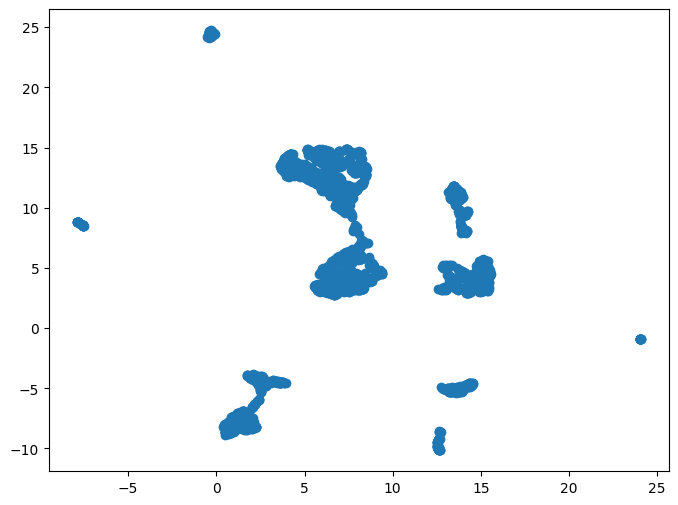

In [35]:
np_train = X.drop(columns=['cat']).to_numpy()
sscaler = StandardScaler()
sscaler.fit(np_train)
np_train = sscaler.transform(np_train)

umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(np_train, state=0)

plt.figure(figsize=(8, 6))
# for key, val in d.items():
#   plt.scatter(X_umap[val, 0], X_umap[val, 1])
plt.scatter(X_umap[:, 0], X_umap[:, 1], )

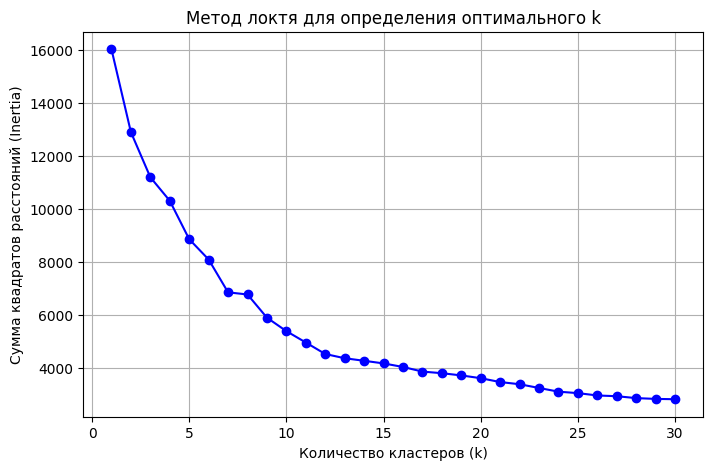

12 норм вроде


In [ ]:
inertia = []
k_range = range(1, 31)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(np_train)
    inertia.append(kmeans.inertia_)

# Построение графика "локтя"
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов расстояний (Inertia)')
plt.title('Метод локтя для определения оптимального k')
plt.grid(True)
plt.show()
print('12 норм вроде')

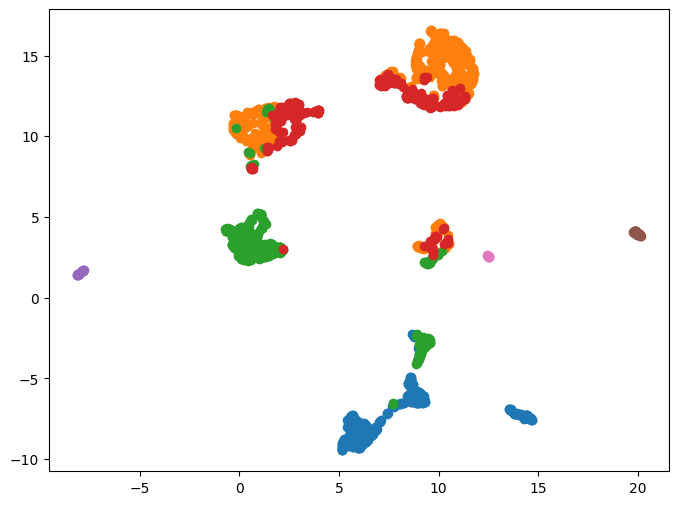

In [ ]:
kmeans =  KMeans(n_clusters=7, random_state=0).fit(np_train)
train_cluster_label = kmeans.predict(np_train)

#np_test = X_test.to_numpy()
#np_test[:, :10] = scaler.transform(np_test[:, :10])
#test_cluster_label = kmeans.predict(np_test)

d = defaultdict(list)
for i in range(kmeans.labels_.shape[0]):
  d[kmeans.labels_[i]].append(i)

plt.figure(figsize=(8, 6))
for key, val in d.items():
  plt.scatter(X_umap[val, 0], X_umap[val, 1])

In [ ]:
t_yyy = y_train.copy()
t_yyy = t_yyy.reset_index()
t_yyy['cluster'] = pd.Series(train_cluster_label)
t_yyy.groupby('cluster').agg(cluster_class=('class', lambda x: np.unique(x, return_counts=True)))
#train_cluster_label, test_cluster_label

,cluster_class
cluster,
0,"([0, 1], [84, 192])"
1,"([0, 1], [104, 219])"
2,"([0, 1], [135, 477])"
3,"([0, 1], [2, 7])"
4,"([0, 1], [15, 20])"
5,"([0], [321])"
6,"([0, 1], [22, 6])"


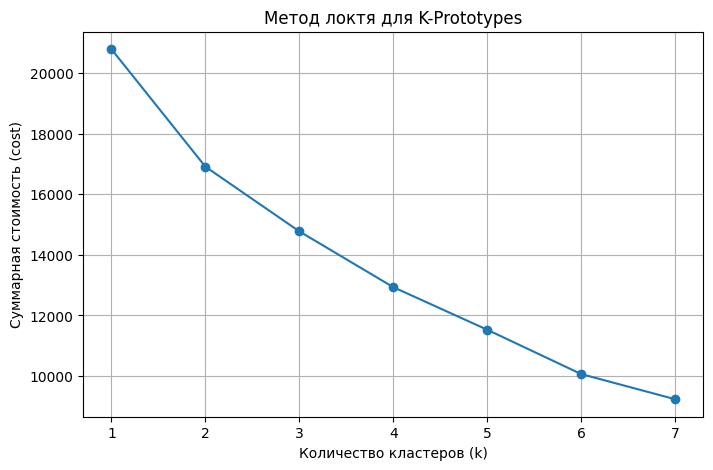

In [36]:
XX_train = X.copy()
cols = ['dist',	'score', 'recency_days',	'total_orders_count',	'monetary_value',	'avg_order_value',	'success_rate_percentage',	'rfm_1', 'rfm_2', 'rfm_3']
scaler = StandardScaler()
XX_train[cols] = scaler.fit_transform(XX_train[cols])
data_matrix = XX_train.values
categorical_cols = [2]

costs = []

for k in range(1, 8):
    kproto = KPrototypes(n_clusters=k, init='Huang', verbose=0, random_state=0)
    kproto.fit_predict(data_matrix, categorical=categorical_cols)
    costs.append(kproto.cost_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 8), costs, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Суммарная стоимость (cost)')
plt.title('Метод локтя для K-Prototypes')
plt.grid(True)
plt.show()

In [38]:
kproto = KPrototypes(n_clusters=6, init='Huang', verbose=0, random_state=0, gamma=1)
train_cluster_label = kproto.fit_predict(data_matrix, categorical=categorical_cols)

t_yyy = Y.copy()
t_yyy = t_yyy.reset_index()
t_yyy['cluster'] = pd.Series(train_cluster_label)
t_yyy.groupby('cluster').agg(cluster_class=('class', lambda x: np.unique(x, return_counts=True)))

,cluster_class
cluster,
0,"([0, 1], [200, 256])"
1,"([0, 1], [28, 7])"
2,"([0, 1], [4, 12])"
3,"([0, 1], [7, 661])"
4,"([0, 1], [591, 190])"
5,"([0, 1], [24, 26])"


In [ ]:
gower_dist = gower.gower_matrix(X_train)

model = DBSCAN(metric='precomputed', eps=0.05, min_samples=30)
train_cluster_label = model.fit_predict(gower_dist)

t_yyy = y_train.copy()
t_yyy = t_yyy.reset_index()
t_yyy['cluster'] = pd.Series(train_cluster_label)
t_yyy.groupby('cluster').agg(cluster_class=('class', lambda x: np.unique(x, return_counts=True)))

,cluster_class
cluster,
-1,"([0, 1, 2], [748, 490, 26])"
0,"([0, 1, 2], [52, 74, 4])"
1,"([0, 1, 2], [1, 47, 8])"
2,"([0, 1, 2], [2, 50, 1])"
3,"([0, 1], [36, 2])"
4,"([0], [32])"
5,"([0], [31])"
